In [3]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
rectangular_ = 1
elliptic_ = 2

In [4]:
round(1.0e6/8)

125000

In [5]:
eSpread = 0.0 
NL_t = 0
CLcut = 2.7


emitGeomRMS = 3.3e-6
npt = round(1.0e6/8)*8
print('npt=',npt)
nturn = 32

npt= 1000000


In [6]:
NL_L = 1.8
NL_c = 0.01
NL_nu = 0.3

betx = NL_L/np.sin(2.0*np.pi*NL_nu)
alfx = np.tan(np.pi*NL_nu)

# read Aperture

In [7]:
aperture = np.loadtxt('pipeinfo.in')

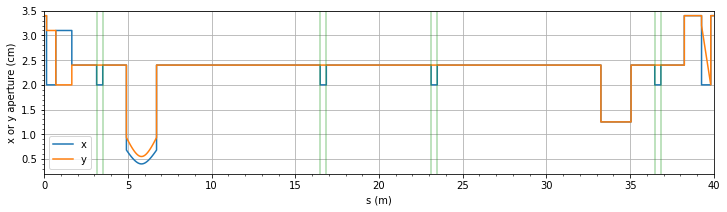

In [8]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.plot(aperture[:,0],(aperture[:,3]-1)*10,alpha=0.4)
plt.grid()
plt.ylim((0.2,3.5))
plt.xlim((0.0, 40))
plt.minorticks_on()
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

In [9]:
aperture[-1,0]

39.968229720000004

In [10]:
def getAperture(z):
    for i in range(1,len(aperture)-1):
        z0 = aperture[i,0]
        z1 = aperture[i+1,0]
        if z0 < z <= z1:
            break
    x = copy(aperture[i,:])
    _x = copy(aperture[i-1,:])
    if np.all(_x[1:] == x[1:]):
        _x = copy(aperture[i-2,:])
    x_ = copy(aperture[i+1,:])
    if np.all(x_[1:] == x[1:]):
        x_ = copy(aperture[i+2,:])
        
    x[1:3] = x[1:3]
    _x[1:3]= _x[1:3]
    x_[1:3]= x_[1:3]
    
    print('z0,z1=',z0,z1)
    print('_x =',_x )
    print(' x =', x )
    print(' x_=', x_)
    return z0,z1,_x,x,x_

In [11]:
print(getAperture(4.95))
print(getAperture(5.82))

z0,z1= 4.91151914 4.954376282857143
_x = [4.91151914 0.024      0.024      2.        ]
 x = [4.91151914 0.00680513 0.00935705 2.        ]
 x_= [4.95437628 0.00659483 0.0090679  2.        ]
(4.91151914, 4.954376282857143, array([4.91151914, 0.024     , 0.024     , 2.        ]), array([4.91151914, 0.00680513, 0.00935705, 2.        ]), array([4.95437628, 0.00659483, 0.0090679 , 2.        ]))
z0,z1= 5.811519140000001 5.854376282857142
_x = [5.768662e+00 4.008580e-03 5.511800e-03 2.000000e+00]
 x = [5.81151914e+00 4.00000000e-03 5.50000000e-03 2.00000000e+00]
 x_= [5.85437628e+00 4.00858000e-03 5.51180000e-03 2.00000000e+00]
(5.811519140000001, 5.854376282857142, array([5.768662e+00, 4.008580e-03, 5.511800e-03, 2.000000e+00]), array([5.81151914e+00, 4.00000000e-03, 5.50000000e-03, 2.00000000e+00]), array([5.85437628e+00, 4.00858000e-03, 5.51180000e-03, 2.00000000e+00]))


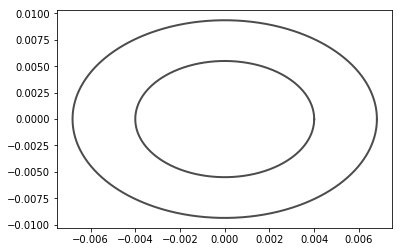

In [12]:
ap0_x,ap0_y = 0.00680513, 0.00935705
ap1_x,ap1_y = 4.00000000e-03, 5.50000000e-03
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)
plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)

# read impact lattice

In [13]:
beam,lattice = impact.readInputFile('test.Chad.in')
beam.nCore_y=4
beam.nCore_z=2
beam.n_particles = npt

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg
print('\n\n emitN =',emitN)

reading ImpactZ input file (test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


 emitN = 2.4105916749973357e-07


In [14]:
cleanLat = impact.clearLattice(lattice)
L = 0 
for item in cleanLat:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if item.type == 'nonlinear_insert':
        print('NL:',L,L+item.length)
    if 'length' in item:
        L = L+item.length
print(L-aperture[-1,0])

NL: 4.9115191429 6.711519142899999
-4.199918635094946e-09


In [15]:
for item in cleanLat:
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1

# Back tracking for IOTA matched beam at injection location

In [11]:
for i in range(len(cleanLat)):
    if cleanLat[i].type == 'nonlinear_insert':
        break

latticeB = impact.getInverseLattice(cleanLat[:i])

In [12]:
TBTentrance = impact.getElem('TBT')
TBTentrance.pID_end = npt
TBTentrance.file_id = 1032

TBTexit = copy(TBTentrance)
TBTexit.file_id = 1033

cleanLat.insert(i,TBTentrance)
cleanLat.insert(i+2,TBTexit)

In [13]:
write0 = impact.getElem('write_raw_ptcl')
write0.file_id = 111110
write0.format_id = 2
latticeB.insert(0,write0)


write1 = impact.getElem('write_raw_ptcl')
write1.file_id = 111111
write1.format_id = 2
latticeB.append(write1)

In [14]:
loop = impact.getElem('loop')
loop.turns = 1
latticeB.insert(0,loop)

In [15]:
beam.distribution.distribution_type = 'IOTA_Gauss'
beam.distribution.NL_t  = NL_t
beam.distribution.NL_c  = NL_c
beam.distribution.betx  = betx
beam.distribution.alfx  = alfx
beam.distribution.emitx = emitGeomRMS
beam.distribution.CL    = CLcut
beam.distribution.betz  = 200
beam.distribution.alfz  = 0.0
beam.distribution.emitz = (eSpread*ke*1.0e-6)**2*beam.distribution.betz

# beam.distribution.distribution_type = 'Gauss'
# beam.distribution.alfx = alfx
# beam.distribution.betx = betx
# beam.distribution.alfy = alfx
# beam.distribution.bety = betx
# beam.distribution.emitx = emitN
# beam.distribution.emity = emitN
# beam.distribution.betz  = 200
# beam.distribution.alfz  = 0.0
# beam.distribution.emitz = (eSpread*ke*1.0e-6)**2*beam.distribution.betz

betx,alfx,emitGeomRMS,beam.distribution.emitz

(1.8926320036288808, 1.3763819204711734, 3.3e-06, 0.0)

In [16]:
impact.writeInputFile(beam,latticeB)
impact.run(beam)

0

In [17]:
pData0 = impact.readParticleData(111110,ke,mass,freq,2)

In [18]:
impact.getTwiss_from_pData(pData0)

/home/kilean/WorkSpace/pImpactR/pImpactR/impactIO.py:1594: RuntimeWarning: invalid value encountered in double_scalars
  betz = varx/emitz
/home/kilean/WorkSpace/pImpactR/pImpactR/impactIO.py:1595: RuntimeWarning: invalid value encountered in double_scalars
  alfz = np.sqrt(varpx/emitz*betz-1)


(1.890641557538947,
 1.3748014012318346,
 2.224579649629633e-06,
 1.8910972280725753,
 1.3747902361605648,
 2.222478215829495e-06,
 nan,
 nan,
 0.0)

In [19]:
# plt.figure(figsize=(10,10))
# plt.subplot(2,2,1)
# plt.scatter(pData0[:,0],pData0[:,1],s=1.0)
# plt.subplot(2,2,2)
# plt.scatter(pData0[:,2],pData0[:,3],s=1.0)
# plt.subplot(2,2,3)
# plt.scatter(pData0[:,4],pData0[:,5],s=1.0)
# plt.subplot(2,2,4)
# plt.scatter(pData0[:,0],pData0[:,2],s=1.0)

In [20]:
pData1 = impact.readParticleData(111111,ke,mass,freq,2)

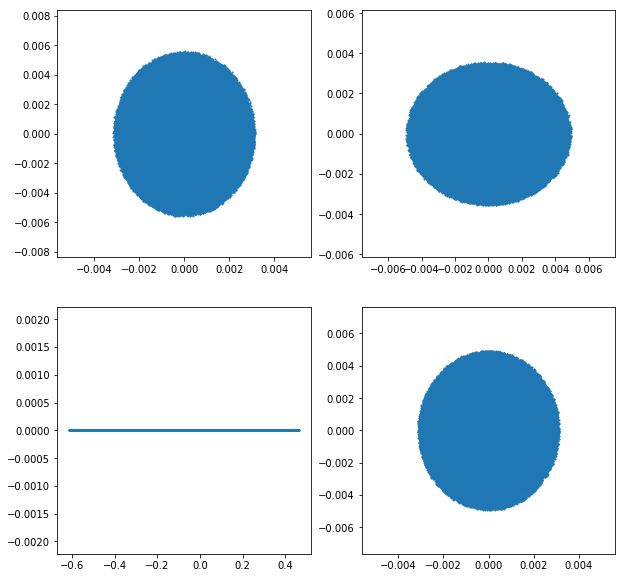

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(pData1[:,0],pData1[:,1],s=1.0)
plt.subplot(2,2,2)
plt.scatter(pData1[:,2],pData1[:,3],s=1.0)
plt.subplot(2,2,3)
plt.scatter(pData1[:,4],pData1[:,5],s=1.0)
plt.subplot(2,2,4)
plt.scatter(pData1[:,0],pData1[:,2],s=1.0)

In [22]:
impact.getTwiss_from_pData(pData1)

/home/kilean/WorkSpace/pImpactR/pImpactR/impactIO.py:1594: RuntimeWarning: divide by zero encountered in double_scalars
  betz = varx/emitz
/home/kilean/WorkSpace/pImpactR/pImpactR/impactIO.py:1595: RuntimeWarning: invalid value encountered in double_scalars
  alfz = np.sqrt(varpx/emitz*betz-1)


(0.5601926127780179,
 0.000474366098036434,
 2.22457895270623e-06,
 1.383940590163128,
 0.0004318617924262324,
 2.222478291784851e-06,
 inf,
 nan,
 0.0)

# run

In [23]:
beam.distribution.distribution_type = 'ReadFile_binary'
beam.distribution.file_id = 111111

In [24]:
# beam.distribution.alfx = 3.860846841e-5
# beam.distribution.betx = 0.561065822
# beam.distribution.alfy = 2.282987698e-9
# beam.distribution.bety = 1.385141718
# beam.distribution.emitx = emitN
# beam.distribution.emity = emitN
# beam.distribution.betz  = 200
# beam.distribution.alfz  = 0.0
# beam.distribution.emitz = (eSpread*ke*1.0e-6)**2*beam.distribution.betz
# beam.distribution.distribution_type = 'IOTA_Gauss'

# run Impact

In [25]:
cleanLat.insert(0,impact.getElem('pipeinfo'))
cleanLat.insert(1,impact.getElem('loop'))
cleanLat[1].turns = nturn

In [26]:
writeP = impact.getElem('write_raw_ptcl')
writeP.file_id = 3456
writeP.format_id = 2
cleanLat.insert(2,writeP)

In [27]:
impact.writeInputFile(beam,cleanLat)
impact.run(beam)

0

In [28]:
lostp = np.loadtxt('lost_partcl.data',skiprows=1, usecols=(0,1,2,4))

In [29]:
lostp.shape

(9244, 4)

In [30]:
np.save('lost_partcl.gauss.cut'+str(CLcut)+'.I=0.NLon.noEspread.npy',lostp)

In [31]:
lostp = np.load('lost_partcl.gauss.cut'+str(CLcut)+'.I=0.NLon.noEspread.npy')

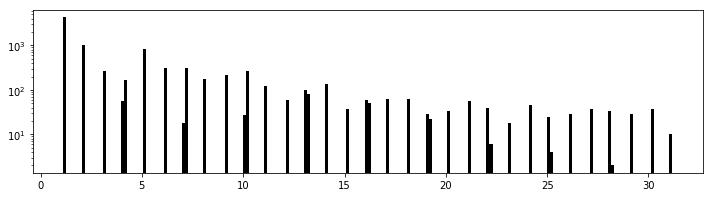

In [32]:
plt.figure(figsize=(12,3))
plt.hist(lostp[:,0]/L,bins=200,color='k');
plt.yscale('log')

In [33]:
lostp[:,0] = np.mod(lostp[:,0],L)
lostp.shape

(9244, 4)

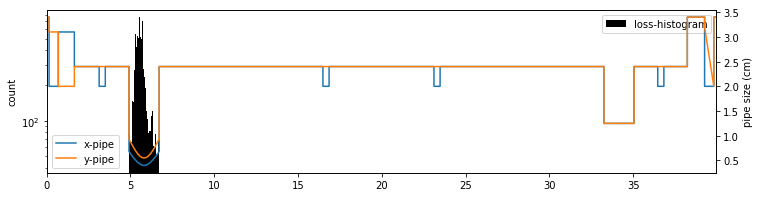

In [34]:
plt.figure(figsize=(12,3))
plt.hist(lostp[:,0],bins=40,color='k');
plt.xlim(0,L)
plt.yscale('log')
plt.ylabel('count')
plt.legend(['loss-histogram'])
plt.twinx()
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.ylabel('pipe size (cm)')
plt.legend(['x-pipe','y-pipe'])

(-0.012, 0.012)

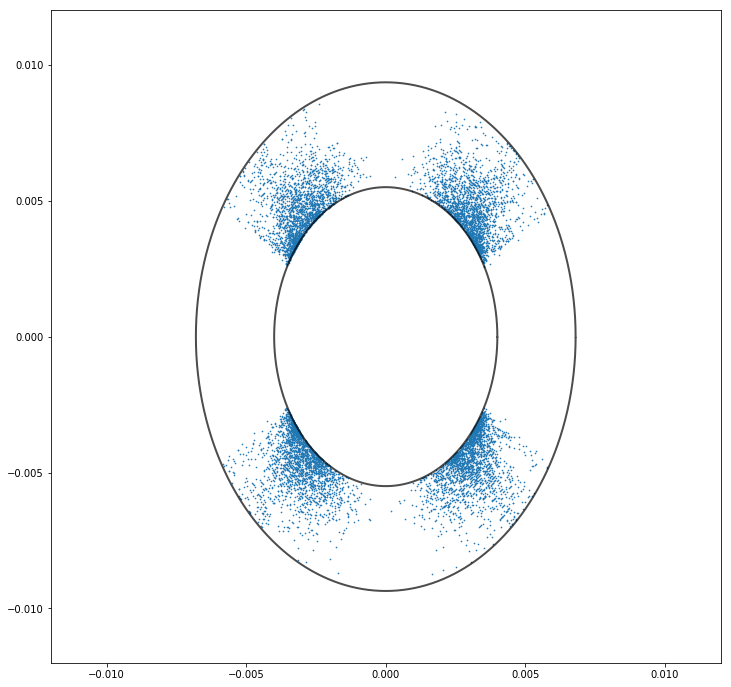

In [63]:
plt.figure(figsize=(12,12))
plt.scatter(lostp[:,1],lostp[:,2],s=0.4)
plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)

# each turn beam distribution at NL entrance and exit

In [16]:
dummy,tbt_enter = impact.readTBT(1032,ke,mass,freq)
dummy,tbt_exit = impact.readTBT(1033,ke,mass,freq)

In [41]:
tbt_enter.shape

(32, 6, 990766)

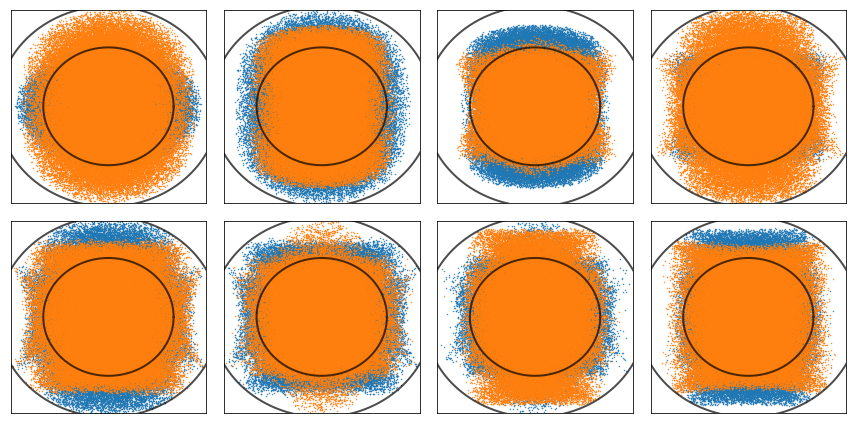

In [23]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.scatter(tbt_enter[i,0,::10],tbt_enter[i,2,::10],s=0.2)
    plt.scatter(tbt_exit [i,0,::10],tbt_exit [i,2,::10],s=0.2)
    plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
    plt.xlim(-0.006,0.006)
    plt.ylim(-0.009,0.009)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=False)
    plt.tight_layout()
    plt.savefig('mismatchedness_of.gauss.cut2.7.nturn=0to8.png',dpi=180)

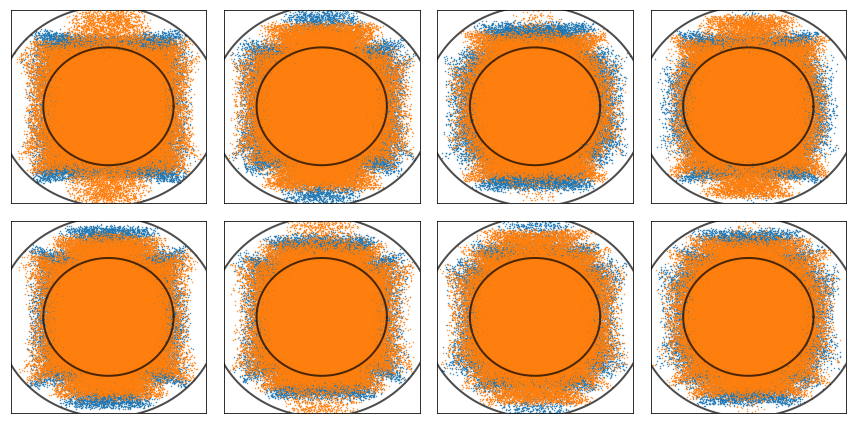

In [25]:
plt.figure(figsize=(12,6))
for i in range(8,16):
    plt.subplot(2,4,i+1-8)
    plt.scatter(tbt_enter[i,0,::10],tbt_enter[i,2,::10],s=0.2)
    plt.scatter(tbt_exit [i,0,::10],tbt_exit [i,2,::10],s=0.2)
    plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
    plt.xlim(-0.006,0.006)
    plt.ylim(-0.009,0.009)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=False)
    plt.tight_layout()
    plt.savefig('mismatchedness_of.gauss.cut2.7.nturn=8to16.png',dpi=180)

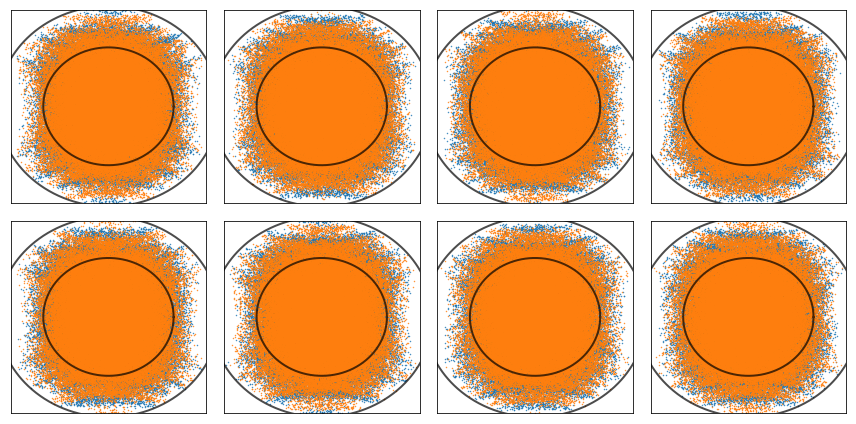

In [26]:
plt.figure(figsize=(12,6))
for i in range(24,32):
    plt.subplot(2,4,i+1-24)
    plt.scatter(tbt_enter[i,0,::10],tbt_enter[i,2,::10],s=0.2)
    plt.scatter(tbt_exit [i,0,::10],tbt_exit [i,2,::10],s=0.2)
    plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
    plt.xlim(-0.006,0.006)
    plt.ylim(-0.009,0.009)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=False)
    plt.tight_layout()
    plt.savefig('mismatchedness_of.gauss.cut2.7.nturn=24to32.png',dpi=180)